# PACKAGES LOADING

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import bz2
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tqdm import tqdm_notebook as tqdm

import model
from align import AlignDlib

%matplotlib inline

from urllib.request import urlopen

def download_landmarks(dst_file):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()
    
    with urlopen(url) as src, open(dst_file, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)

dst_dir = 'models'
dst_file = os.path.join(dst_dir, 'landmarks.dat')

if not os.path.exists(dst_file):
    os.makedirs(dst_dir)
    download_landmarks(dst_file)

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

/usr/local/anaconda3/envs/x_hec_face_reco/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# DATA LOADING

In [3]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in sorted(os.listdir(path)):
        try:
            for f in sorted(os.listdir(os.path.join(path, i))):
                # Check file extension. Allow only jpg/jpeg' files.
                ext = os.path.splitext(f)[1]
                if ext == '.jpg' or ext == '.JPG' or ext == '.jpeg':
                    metadata.append(IdentityMetadata(path, i, f))
        except NotADirectoryError:
            pass
    return np.array(metadata)

metadata = load_metadata('images/train_images')

# FACE DETECTION

The nn4.small2.v1 model was trained with aligned face images, therefore, the face images from the custom dataset must be aligned too. Here, we use [Dlib](http://dlib.net/) for face detection and [OpenCV](https://opencv.org/) for image transformation and cropping to produce aligned 96x96 RGB face images. By using the [AlignDlib](align.py) utility from the OpenFace project this is straightforward:

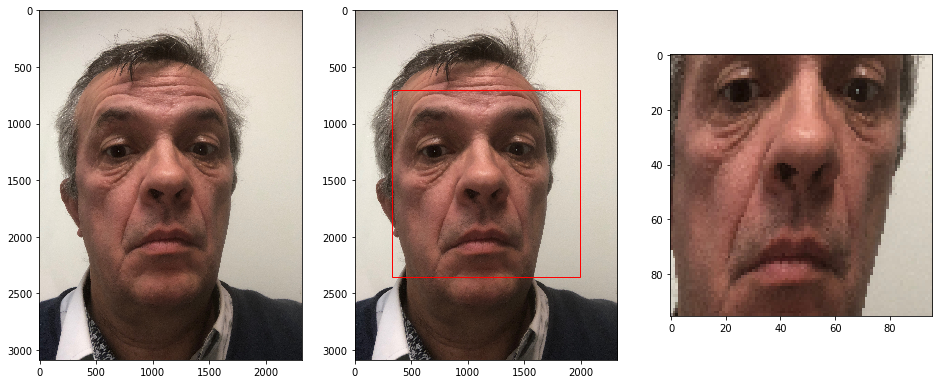

In [6]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('models/landmarks.dat')

jc_orig = load_image(metadata[70].image_path())

# Detect face and return bounding box
bb = alignment.getLargestFaceBoundingBox(jc_orig)

# Transform image using specified face landmark indices and crop image to 96x96
jc_aligned = alignment.align(96, jc_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
plt.figure(figsize=(16,16))
# Show original image
plt.subplot(131)
plt.imshow(jc_orig)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(jc_aligned);

As described in the OpenFace [pre-trained models](https://cmusatyalab.github.io/openface/models-and-accuracies/#pre-trained-models) section, landmark indices `OUTER_EYES_AND_NOSE` are required for model nn4.small2.v1. Let's implement face detection, transformation and cropping as `align_image` function for later reuse.

In [6]:
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

.

# FACE ENCODING

## Transfer learning and embedding vectors

In [8]:
nn4_small2 = model.create_model()
nn4_small2.load_weights('weights/nn4.small2.v1.h5')

In [9]:
def embed(image_path):
    img = load_image(image_path)
    img = align_image(img)
    # scale RGB values to interval [0,1]
    img = (img / 255.).astype(np.float32)
    # obtain embedding vector for image
    embedded = nn4_small2.predict(np.expand_dims(img, axis=0))[0]
    
    return embedded

In [10]:
embedded = np.zeros((metadata.shape[0], 128))

for i in tqdm(range(metadata.shape[0])):
    m = metadata[i]
    try:
        embedded[i] = embed(m.image_path())
    except TypeError:
        print(m)

HBox(children=(IntProgress(value=0, max=95), HTML(value='')))

images/train_images/Adrien_R/Adrien R (12).JPG
images/train_images/Adrien_R/Adrien R (5).JPG
images/train_images/Adrien_R/Adrien R (6).JPG
images/train_images/Charles_D/Charles D (5).jpg
images/train_images/Olivier_A/Olivier A (5).JPG
images/train_images/Olivier_A/Olivier A (6).JPG
images/train_images/Olivier_A/Olivier A (7).JPG
images/train_images/Olivier_A/Olivier A (8).JPG
images/train_images/Olivier_A/Olivier A (9).JPG
images/train_images/Zakaria B/Zakaria B (10).jpg



In [13]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

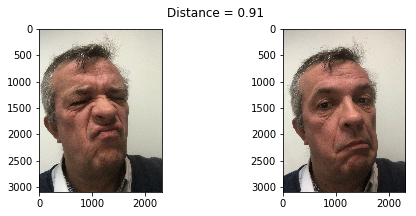

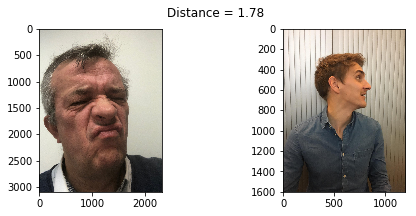

In [14]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(10,10))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(77, 76)
show_pair(77, 21)

As expected, the distance between the two images of the same person is smaller than the distance between two images of different people. But we still do not know what distance threshold $\tau$ is the best boundary for making a decision between *same identity* and *different identity*.

### Distance threshold

To find the optimal value for $\tau$, the face verification performance must be evaluated on a range of distance threshold values. At a given threshold, all possible embedding vector pairs are classified as either *same identity* or *different identity* and compared to the ground truth. Since we're dealing with skewed classes (much more negative pairs than positive pairs), we use the [F1 score](https://en.wikipedia.org/wiki/F1_score) as evaluation metric instead of [accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html).

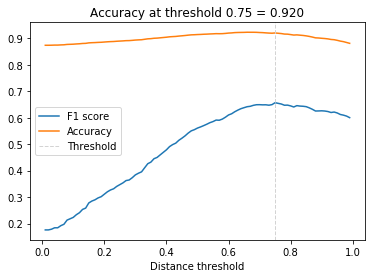

In [15]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.01, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

.

# FACE IDENTIFICATION

Given an estimate of the distance threshold $\tau$, face recognition is now as simple as calculating the distances between an input embedding vector and all embedding vectors in a database. The input is assigned the label (i.e. identity) of the database entry with the smallest distance if it is less than $\tau$ or label *unknown* otherwise. This procedure can also scale to large databases as it can be easily parallelized. It also supports one-shot learning, as adding only a single entry of a new identity might be sufficient to recognize new examples of that identity.

A more robust approach is to label the input using the top $k$ scoring entries in the database which is essentially [KNN classification](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) with a Euclidean distance metric. Alternatively, a linear [support vector machine](https://en.wikipedia.org/wiki/Support_vector_machine) (SVM) can be trained with the database entries and used to classify i.e. identify new inputs. For training these classifiers we use 50% of the dataset, for evaluation the other 50%.

In [18]:
targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0

# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 0.8541666666666666, SVM accuracy = 0.9166666666666666


## Load Validation data

In [23]:
val_images = []
for file in os.listdir("images/val_images"):
    if "jpg" in file or "jpeg" in file or "JPG" in file:
        val_images.append(os.path.join("images", "val_images",file))

/usr/local/anaconda3/envs/x_hec_face_reco/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


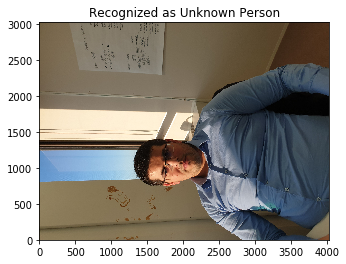

In [30]:
example_idx = 2

embedded_test = embed(val_images[example_idx])
example_prediction = svc.predict([embedded_test])
example_identity = encoder.inverse_transform(example_prediction)[0]

p = svc.decision_function(np.array([embedded_test]))
probs = np.concatenate(np.exp(p)/np.sum(np.exp(p),axis=1))

example_image = plt.imread(val_images[example_idx])
plt.imshow(np.flipud(example_image), origin='lower')

if probs.max()>0.25:
    plt.title(f'Recognized as {example_identity}');
else:
    plt.title(f'Recognized as Unknown Person')

.

# TWO FACES ON AN IMAGE

In [31]:
two_faces = []
for file in os.listdir("images/two_faces"):
    if "jpg" in file or "jpeg" in file or "JPG" in file:
        two_faces.append(os.path.join("images", "two_faces", file))

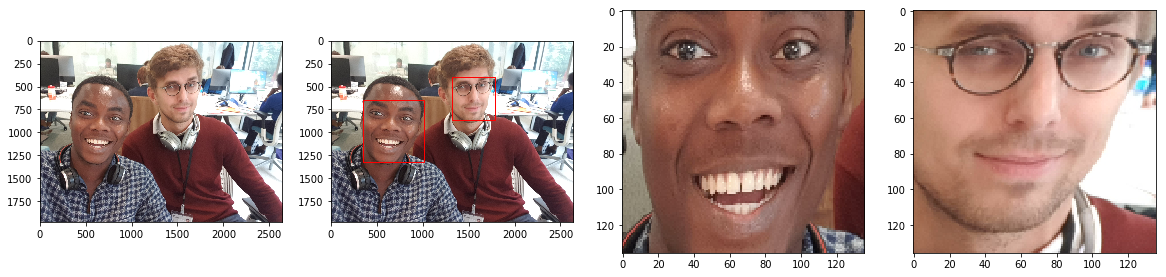

In [32]:
# Load an image of Olivier Auliard
jc_orig = load_image(two_faces[0])

plt.figure(figsize=(20,20))

# get all faces boundingboxes
bb = alignment.getAllFaceBoundingBoxes(jc_orig)

plt.subplot(141)
plt.imshow(jc_orig)

jc_aligned_0 = alignment.align(136, jc_orig, bb[0], landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
jc_aligned_1 = alignment.align(136, jc_orig, bb[1], landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)


# Show original image with bounding box
plt.subplot(142)
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb[0].left(), bb[0].top()), bb[0].width(), bb[0].height(), fill=False, color='red'))
plt.gca().add_patch(patches.Rectangle((bb[1].left(), bb[1].top()), bb[1].width(), bb[1].height(), fill=False, color='red'))

# Show aligned image
plt.subplot(143)
plt.imshow(jc_aligned_0)

plt.subplot(144)
plt.imshow(jc_aligned_1);

In [33]:
n_faces=2

def align_images(img, n_faces):    
    bbs = alignment.getAllFaceBoundingBoxes(img)    
    aligns = np.array([alignment.align(96, img, bbs[i], landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE) for i in range(n_faces)])    
    return aligns

In [35]:
img = load_image(two_faces[0])
img = align_images(img, n_faces)
try:
    # scale RGB values to interval [0,1]
    img = (img / 255.).astype(np.float32)
    # obtain embedding vector for image
    embedded_test = []
    for i in range(n_faces):
        embedded_test.append(nn4_small2.predict(np.expand_dims(img[i], axis=0))[0])
except TypeError:
    print("Doesn't work")

In [39]:
thresh = 0.25

def predict_image(image_path, n_faces=2):
    
    example_image = load_image(image_path)
    example_prediction = svc.predict(embedded_test)
    identities = list((encoder.inverse_transform(example_prediction)))
    probs = []
    for i in range(n_faces):
        p = svc.decision_function(np.array([embedded_test[i]]))
        probs.append(np.concatenate(np.exp(p)/np.sum(np.exp(p),axis=1)))   
    plt.imshow(example_image)
    
    max_values = [x.max() for x in probs]
    
    people = []
    if max_values[0]>thresh:
        people.append(identities[0])
    else:
        people.append('Unknown Person')
    
    if max_values[1]>thresh:
        people.append(identities[1])
    else:
        people.append('Unknown Person')
    
    people = ' and '.join(people)
    return plt.title(f'Recognized as {people}')

/usr/local/anaconda3/envs/x_hec_face_reco/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Text(0.5,1,'Recognized as Charles_D and Arthur_B')

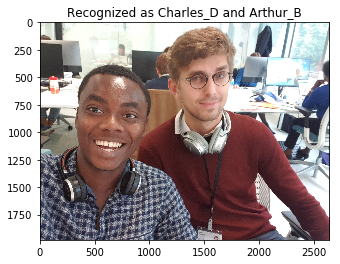

In [40]:
predict_image(two_faces[0])